In [11]:
# загрузим необходимые библиотеки
import pandas as pd
import numpy as np

import requests
import os
import sys
import pathlib
import yaml

import dask.bag as bag
import skimage
from PIL import Image
import cv2

import matplotlib.pyplot as plt
import seaborn as sns

from typing import *

import tqdm

import warnings
warnings.filterwarnings('ignore')

# Data load

**Источник данных**

Данные получены с сайта GBIF. 

GBIF — Глобальный информационный фонд по биоразнообразию — это международная сеть и инфраструктура данных, финансируемая правительствами стран мира и направленная на предоставление любому человеку в любом месте открытого доступа к данным обо всех видах жизни на Земле.

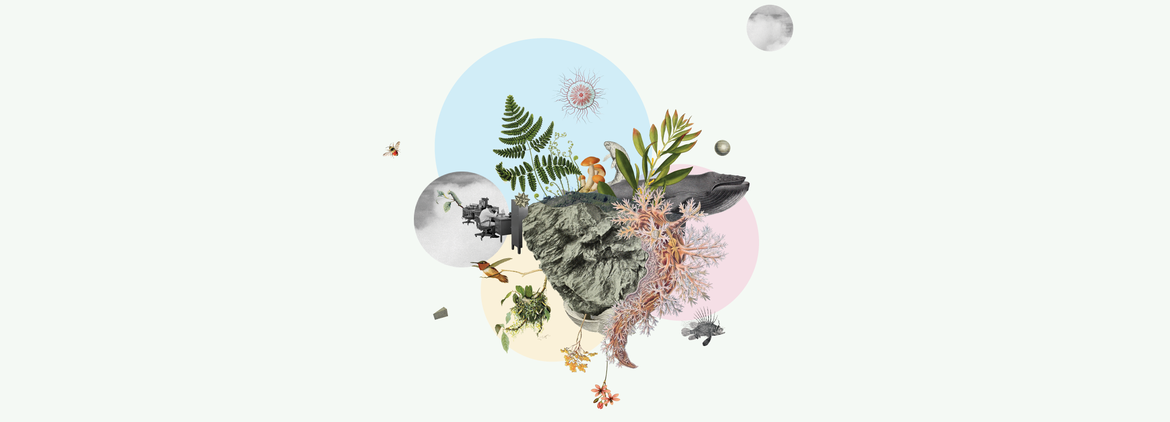

*Список используемых ресурсов:*

```
GBIF.org (22 March 2024) GBIF Occurrence Download https://doi.org/10.15468/dl.5y8e9v
GBIF.org (22 March 2024) GBIF Occurrence Download https://doi.org/10.15468/dl.mwhkp7
GBIF.org (22 March 2024) GBIF Occurrence Download https://doi.org/10.15468/dl.qeykw8
GBIF.org (22 March 2024) GBIF Occurrence Download https://doi.org/10.15468/dl.t7kjqb
GBIF.org (22 March 2024) GBIF Occurrence Download https://doi.org/10.15468/dl.ag46f4
GBIF.org (22 March 2024) GBIF Occurrence Download https://doi.org/10.15468/dl.mhzjgg
GBIF.org (22 March 2024) GBIF Occurrence Download https://doi.org/10.15468/dl.c6phkv
GBIF.org (22 March 2024) GBIF Occurrence Download https://doi.org/10.15468/dl.fwf425
GBIF.org (22 March 2024) GBIF Occurrence Download https://doi.org/10.15468/dl.6rws37
GBIF.org (28 March 2024) GBIF Occurrence Download https://doi.org/10.15468/dl.vzqpxy
GBIF.org (28 March 2024) GBIF Occurrence Download https://doi.org/10.15468/dl.9qt846
GBIF.org (28 March 2024) GBIF Occurrence Download https://doi.org/10.15468/dl.xty8vx
```

## Load on computer

In [9]:
config_path = '../config/params.yml'
config = yaml.load(open(config_path), Loader=yaml.FullLoader)


preproc = config['preprocessing']

**Создадим файл, в котором содержатся ссылки на фото**

In [14]:
def url_to_file(folder_raw: str, folder_interim: str, name: str) -> None:
    """
    Создает файл с ссылками на фото.

    Parameters:
    -----------
    folder_raw: str
        Путь до папки с raw данными.
    folder_interim: str
        Путь до папки для сохранения txt файла.
    name: str
        Название файла.

    Returns:
    --------
    None
        Создает файл txt, в котором содержатся ссылки на фотографии.
    """
    # прочитаем файл, в котором есть информация с ссылками на фото
    df = pd.read_csv(f'{folder_raw}{name}/multimedia.txt', delimiter='\t')
    # создадим список с ссылками
    lst_img = df.identifier.to_list()
    # запишем список ссылок в файл txt
    with open(f'{folder_interim}{name}.txt', "w", encoding="utf-8") as f:
        for item in lst_img:
            f.write(f"{item}\n")
        f.close()

In [16]:
url_to_file(folder_raw=preproc['raw_data_path'],
            folder_interim=preproc['interim_data_path'],
            name='leucanthemum_vulgare')

**Скачаем фото по ссылкам из файла (с учетом того, что есть разные файлы с одинаковым названием):**

Для этого будем использовать WGET (*ссылка на скачивание - https://eternallybored.org/misc/wget/*)

```
wget.exe --tries=1 -i leucanthemum_vulgare.txt --secure-protocol=auto -P leucanthemum_vulgare
```

- --tries=1 количество попыток подключения по ссылке;
- -i и дальше путь для файла со списком URL для скачивания;
- —secure-protocol=auto — используем, если на сайте защищенный протокол HTTPS;
- -P и дальше папка, куда сохранять данные;


**Изменим формат файлов, у которых было одинаковое название:**

```
for %i in (original.jpeg.* original.jpg.* original.png.*) do ren "%i" "%~ni%~xi.jpg"

for %i in (medium.jpeg.* medium.jpg.* medium.png.*) do ren "%i" "%~ni%~xi.jpg"

for %i in (original..* ) do ren "%i" "%~ni%~xi.jpg"

for %i in (medium.jpeg@* medium.jpg@*) do ren "%i" "%~ni%~xi.jpg"
```

**Изменим расширение файлов на .jpg:**

```
ren *. *.jpg
```

# Data preprocessing

## Impot data

In [20]:
# определим путь до общей папки
img_path = f'{preproc['interim_data_path']}Images'
# определим папки с фотографиями классов
img_classes = [
    'anthemis_arvensis', 'anthemis_cotula', 'anthemis_ruthenica',
    'leucanthemum_vulgare', 'matricaria_chamomilla', 'matricaria_discoidea',
    'tanacetum_corymbosum', 'tanacetum_parthenium', 'tripleurospermum_inodorum'
]

In [3]:
# список изображений по классам
imgs = [
    sorted(os.listdir(f'{img_path}/{cls_name}')) for cls_name in img_classes
]

# количество экземпляров классов
cls_count = [len(img_class) for img_class in imgs]

# путь до папок с классами
directories = {}
for cls in img_classes:
    directories[cls] = os.path.join(img_path, cls)

## Size of classes

In [4]:
# определим функцию для отрисовки графика
def barplot_make(cls_name: list, cls_num: list) -> None:
    """
    Построение barplot по количеству и в процентах.
    
    Parameters
    ----------
    cls_name: list
        Метки классов.
    cls_num: list
        Количество экземпляров в каждом классе.
        
    Returns
    -------
    None
        Выводит графики barplot по количеству и в процентах.
    """
    # общее число экземпляров
    image_count = sum(cls_num)
    
    # отобразим графики
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))

    # график с количеством экземпляров в каждом классе
    sns.barplot(x=cls_name,
                y=cls_num,
                palette='viridis',
                ax=axes[0])
    axes[0].set_title("Number of images by class", fontsize=16)
#     axes[0].set_xlabel('Class name', fontsize=14, )
    axes[0].set_ylabel('Number of images', fontsize=14)
    axes[0].text(0.0,
                 -0.5,
                 f'Total number of images: {image_count}',
                 fontsize=12,
                 horizontalalignment='center',
                 verticalalignment='center',
                 transform=axes[0].transAxes
                )
    axes[0].set_xticklabels(cls_name, rotation=45, ha='right')

    # посчитаем в процентах
    percentage = [num / image_count * 100 for num in cls_num]

    # график с соотношением классов в процентном соотношении
    ax = sns.barplot(x=cls_name,
                     y=percentage,
                     palette='viridis',
                     ax=axes[1])

    for p in ax.patches:
        percentage = '{:.1f}%'.format(p.get_height())
        if p.get_height() != 0:
            ax.annotate(
                percentage,  # текст
                # координата xy
                (p.get_x() + p.get_width() / 2., p.get_height()),
                # центрирование
                ha='center',
                va='center',
                xytext=(0, 7),
                # точка смещения относительно координаты
                textcoords='offset points',
                fontsize=12)

    axes[1].set_title('Ratio of classes in percentage', fontsize=16)
#     axes[1].set_xlabel('Class name', fontsize=14)
    axes[1].set_ylabel('Percent', fontsize=14)
    axes[1].set_xticklabels(cls_name, rotation=45, ha='right')
    
    plt.show()

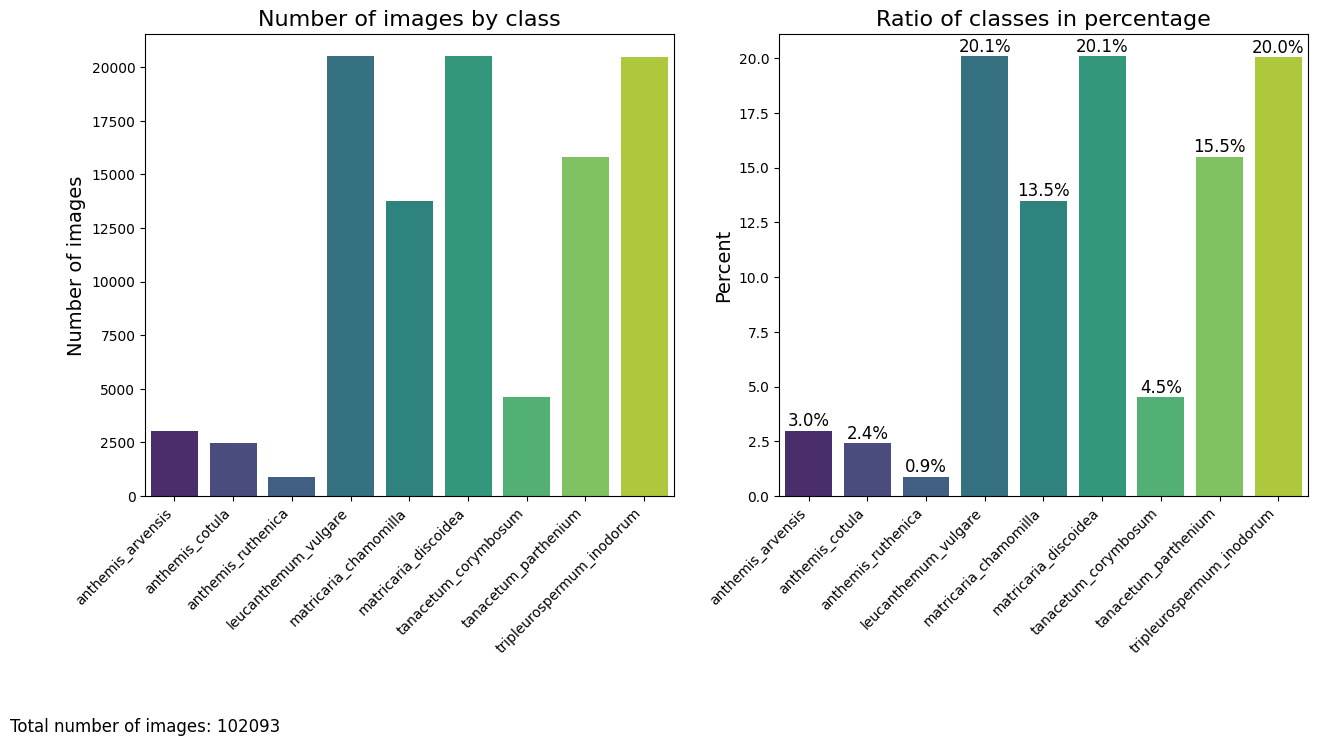

In [5]:
barplot_make(cls_name=img_classes, cls_num=cls_count)

**Вывод:**
    
- наблюдается дисбаланс классов;
- объединим виды anthemis и tanacetum, каждый отдельно

## Size of images

Посмотрим размеры изображений на примере 10 фото от каждого класса

In [6]:
def get_dims(file: str) -> tuple[int, int]:
    """
    Возвращает размеры RGB изображения.
    
    Parameters
    ----------
    file: str
        Путь к файлу изображения.
        
    Returns
    -------
    tuple[int, int]
        Кортеж с высотой и шириной изображения.
    """
    im = Image.open(file)
    arr = np.array(im)
    h, w, d = arr.shape
    
    return h, w


def image_size_plot(directories: dict[str, str]) -> None:
    """
    Строит график размеров изображений по классам.
    
    Parameters
    ----------
    directories : dict[str, str]
        Словарь с именами классов и путями к папкам с изображениями.
        
    Returns
    -------
    None
        Выводит график размеров изображений по классам.
    """
    plt.figure(figsize=(15, 10))
    ncols = 3
    nrows = len(img_classes) // 3 + 1

    for i, (n, d) in tqdm.tqdm(enumerate(directories.items())):
        filepath = d
        filelist = [filepath + '/' + f for f in os.listdir(filepath)[:10]]
        dims = bag.from_sequence(filelist).map(get_dims)
        dims = dims.compute()
        dim_df = pd.DataFrame(dims, columns=['height', 'width'])
        sizes = dim_df.groupby(
            ['height',
             'width']).size().reset_index().rename(columns={0: 'count'})
        plt.subplot(nrows, ncols, i + 1)
        sns.scatterplot(
            data=dim_df,
            x='width',
            y='height',
            palette='viridis',
        )
        plt.title('Image Sizes (pixels) | {}'.format(n))
    plt.tight_layout()
    plt.show()

9it [00:05,  1.52it/s]


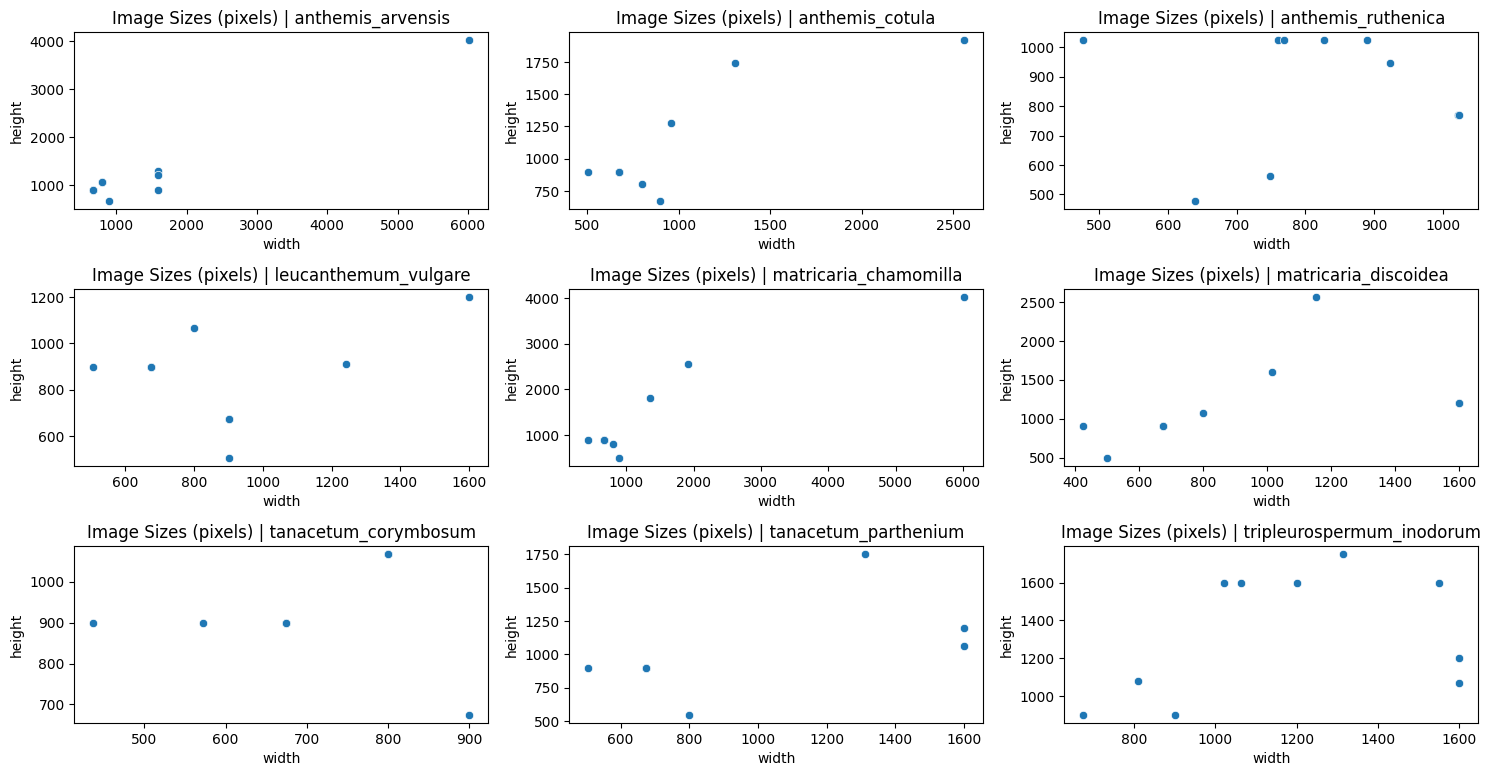

In [7]:
image_size_plot(directories)

**Вывод:**
    
- наблюдается большой разброс размеров;
- приведем размеры в единому формату

## Resize load

In [14]:
directories

{'anthemis_arvensis': 'Images\\anthemis_arvensis',
 'anthemis_cotula': 'Images\\anthemis_cotula',
 'anthemis_ruthenica': 'Images\\anthemis_ruthenica',
 'leucanthemum_vulgare': 'Images\\leucanthemum_vulgare',
 'matricaria_chamomilla': 'Images\\matricaria_chamomilla',
 'matricaria_discoidea': 'Images\\matricaria_discoidea',
 'tanacetum_corymbosum': 'Images\\tanacetum_corymbosum',
 'tanacetum_parthenium': 'Images\\tanacetum_parthenium',
 'tripleurospermum_inodorum': 'Images\\tripleurospermum_inodorum'}

In [26]:
def resize_img(folder_img: str, folder_prep: str, name: str):
    """
    Изменяет размер изображений и сохраняет их.

    Parameters:
    -----------
    folder_img: str
        Путь до папки с изображениями.
    folder_prep: str
        Путь до папки для сохранения обработанных изображений.
    name: str
        Название файла.

    Returns:
    --------
    None
        Изменяет размер изображений и сохраняет их.
    """
    input_folder = f'{folder_img}Images/{name}'
    output_folder = f'{folder_prep}{name}'

    if not os.path.exists(output_folder):
        os.makedirs(output_folder)
    for filename in os.listdir(input_folder):
        if filename.endswith('.jpg') or filename.endswith(
                '.png') or filename.endswith('.jpeg'):
            with Image.open(os.path.join(input_folder, filename)) as img:
                img_resized = img.resize((224, 224))
                if img_resized.mode == 'RGB':
                    img_resized.save(os.path.join(output_folder, filename))
                else:
                    rgb_im = img_resized.convert('RGB')
                    rgb_im.save(os.path.join(output_folder, filename))

In [27]:
for cls_name in tqdm.tqdm(img_classes):
    resize_img(folder_img=preproc['interim_data_path'],
               folder_prep=preproc['img_path_proc'],
               name=cls_name)

100%|███████████████████████████████████████████████████████████████████████████████████| 9/9 [50:03<00:00, 333.69s/it]


## Load to dataset

Сохраним датасет с фотографиями, разделим на train и test

**1. Создадим датасет с путем к фотографиям и метками классов**

In [21]:
# определим новый путь до папки с изображениями
img_path = preproc['img_path_proc']

In [22]:
img_list = []
label_list = []
for label in img_classes:
    for img_file in os.listdir(img_path + '/' + label):
        img_list.append(img_path + '/' + label + '/' + img_file)
        label_list.append(label)

In [23]:
df_cls = pd.DataFrame({'img': img_list, 'label': label_list})

Посмотрим на датасет

In [24]:
df_cls.head()

,img,label
0,../data/processed/train//anthemis_arvensis/001...,anthemis_arvensis
1,../data/processed/train//anthemis_arvensis/001...,anthemis_arvensis
2,../data/processed/train//anthemis_arvensis/001...,anthemis_arvensis
3,../data/processed/train//anthemis_arvensis/00e...,anthemis_arvensis
4,../data/processed/train//anthemis_arvensis/00e...,anthemis_arvensis


In [25]:
df_cls.shape

(102086, 2)

In [26]:
df_cls.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 102086 entries, 0 to 102085
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   img     102086 non-null  object
 1   label   102086 non-null  object
dtypes: object(2)
memory usage: 1.6+ MB


In [27]:
df_cls.describe()

,img,label
count,102086,102086
unique,102086,9
top,../data/processed/train//anthemis_arvensis/001...,matricaria_discoidea
freq,1,20515


**2. Объединим виды пупавки и пиретрума.**

In [28]:
# определим функцию для объединения видов
def merge_class(label: str) -> str:
    """
    Объединяет отдельно виды пупавки и пиретрума.

    Parameters:
    -----------
    label: str
        Название вида.

    Returns:
    --------
    str
        Измененное название.
    """
    if 'anthemis' in label:
        return 'anthemis_spec'
    elif 'tanacetum' in label:
        return 'pyrethrum_spec'

    return label

In [29]:
# применим функцию
df_cls['label'] = df_cls['label'].apply(merge_class)

In [30]:
df_cls.describe()

,img,label
count,102086,102086
unique,102086,6
top,../data/processed/train//anthemis_arvensis/001...,matricaria_discoidea
freq,1,20515


**3. Сохраним csv файл**

In [33]:
df_cls.to_csv(f"{preproc['train_path_proc']}", index=False)